In [77]:
import pandas as pd

from src.features.select_features import get_feature_importance
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()

feature_importance_linear = get_feature_importance(type="Linear", df=dataframe)
feature_importance_forest = get_feature_importance(type="RandomForest", df=dataframe)
feature_importance_tree = get_feature_importance(type="Tree", df=dataframe)

feature_importance = pd.merge(feature_importance_linear, feature_importance_tree, left_index=True, right_index=True, how='inner', suffixes=("", "_tree"))
feature_importance = pd.merge(feature_importance, feature_importance_forest, left_index=True, right_index=True, how='inner', suffixes=("", "_forest"))
feature_importance.info

<bound method DataFrame.info of                               Importance  Importance_tree  Importance_forest
fossil_electricity          1.340718e+14     1.982805e-03           0.046932
electricity_generation      4.454161e+13     1.966291e-04           0.016634
electricity_demand          4.290019e+13     1.134459e-05           0.000678
low_carbon_electricity      2.862544e+13     6.180208e-06           0.000226
renewables_elec_per_capita  1.731277e+07     7.031382e-06           0.000131
...                                  ...              ...                ...
oil_electricity            -1.116665e+13     5.204148e-02           0.007536
nuclear_electricity        -3.012263e+13     1.564933e-07           0.000066
renewables_electricity     -3.445616e+13     4.763455e-08           0.001465
gas_electricity            -5.928485e+13     4.732041e-05           0.000082
coal_electricity           -1.567465e+14     3.727112e-06           0.044109

[101 rows x 3 columns]>

In [79]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
numeric_cols = feature_importance.select_dtypes(include=['number']).columns.difference(['year']).tolist()
feature_importance[numeric_cols] = feature_importance[numeric_cols].abs()
scalar.fit(feature_importance[numeric_cols])
feature_importance[numeric_cols] = scalar.transform(feature_importance[numeric_cols])

<Axes: >

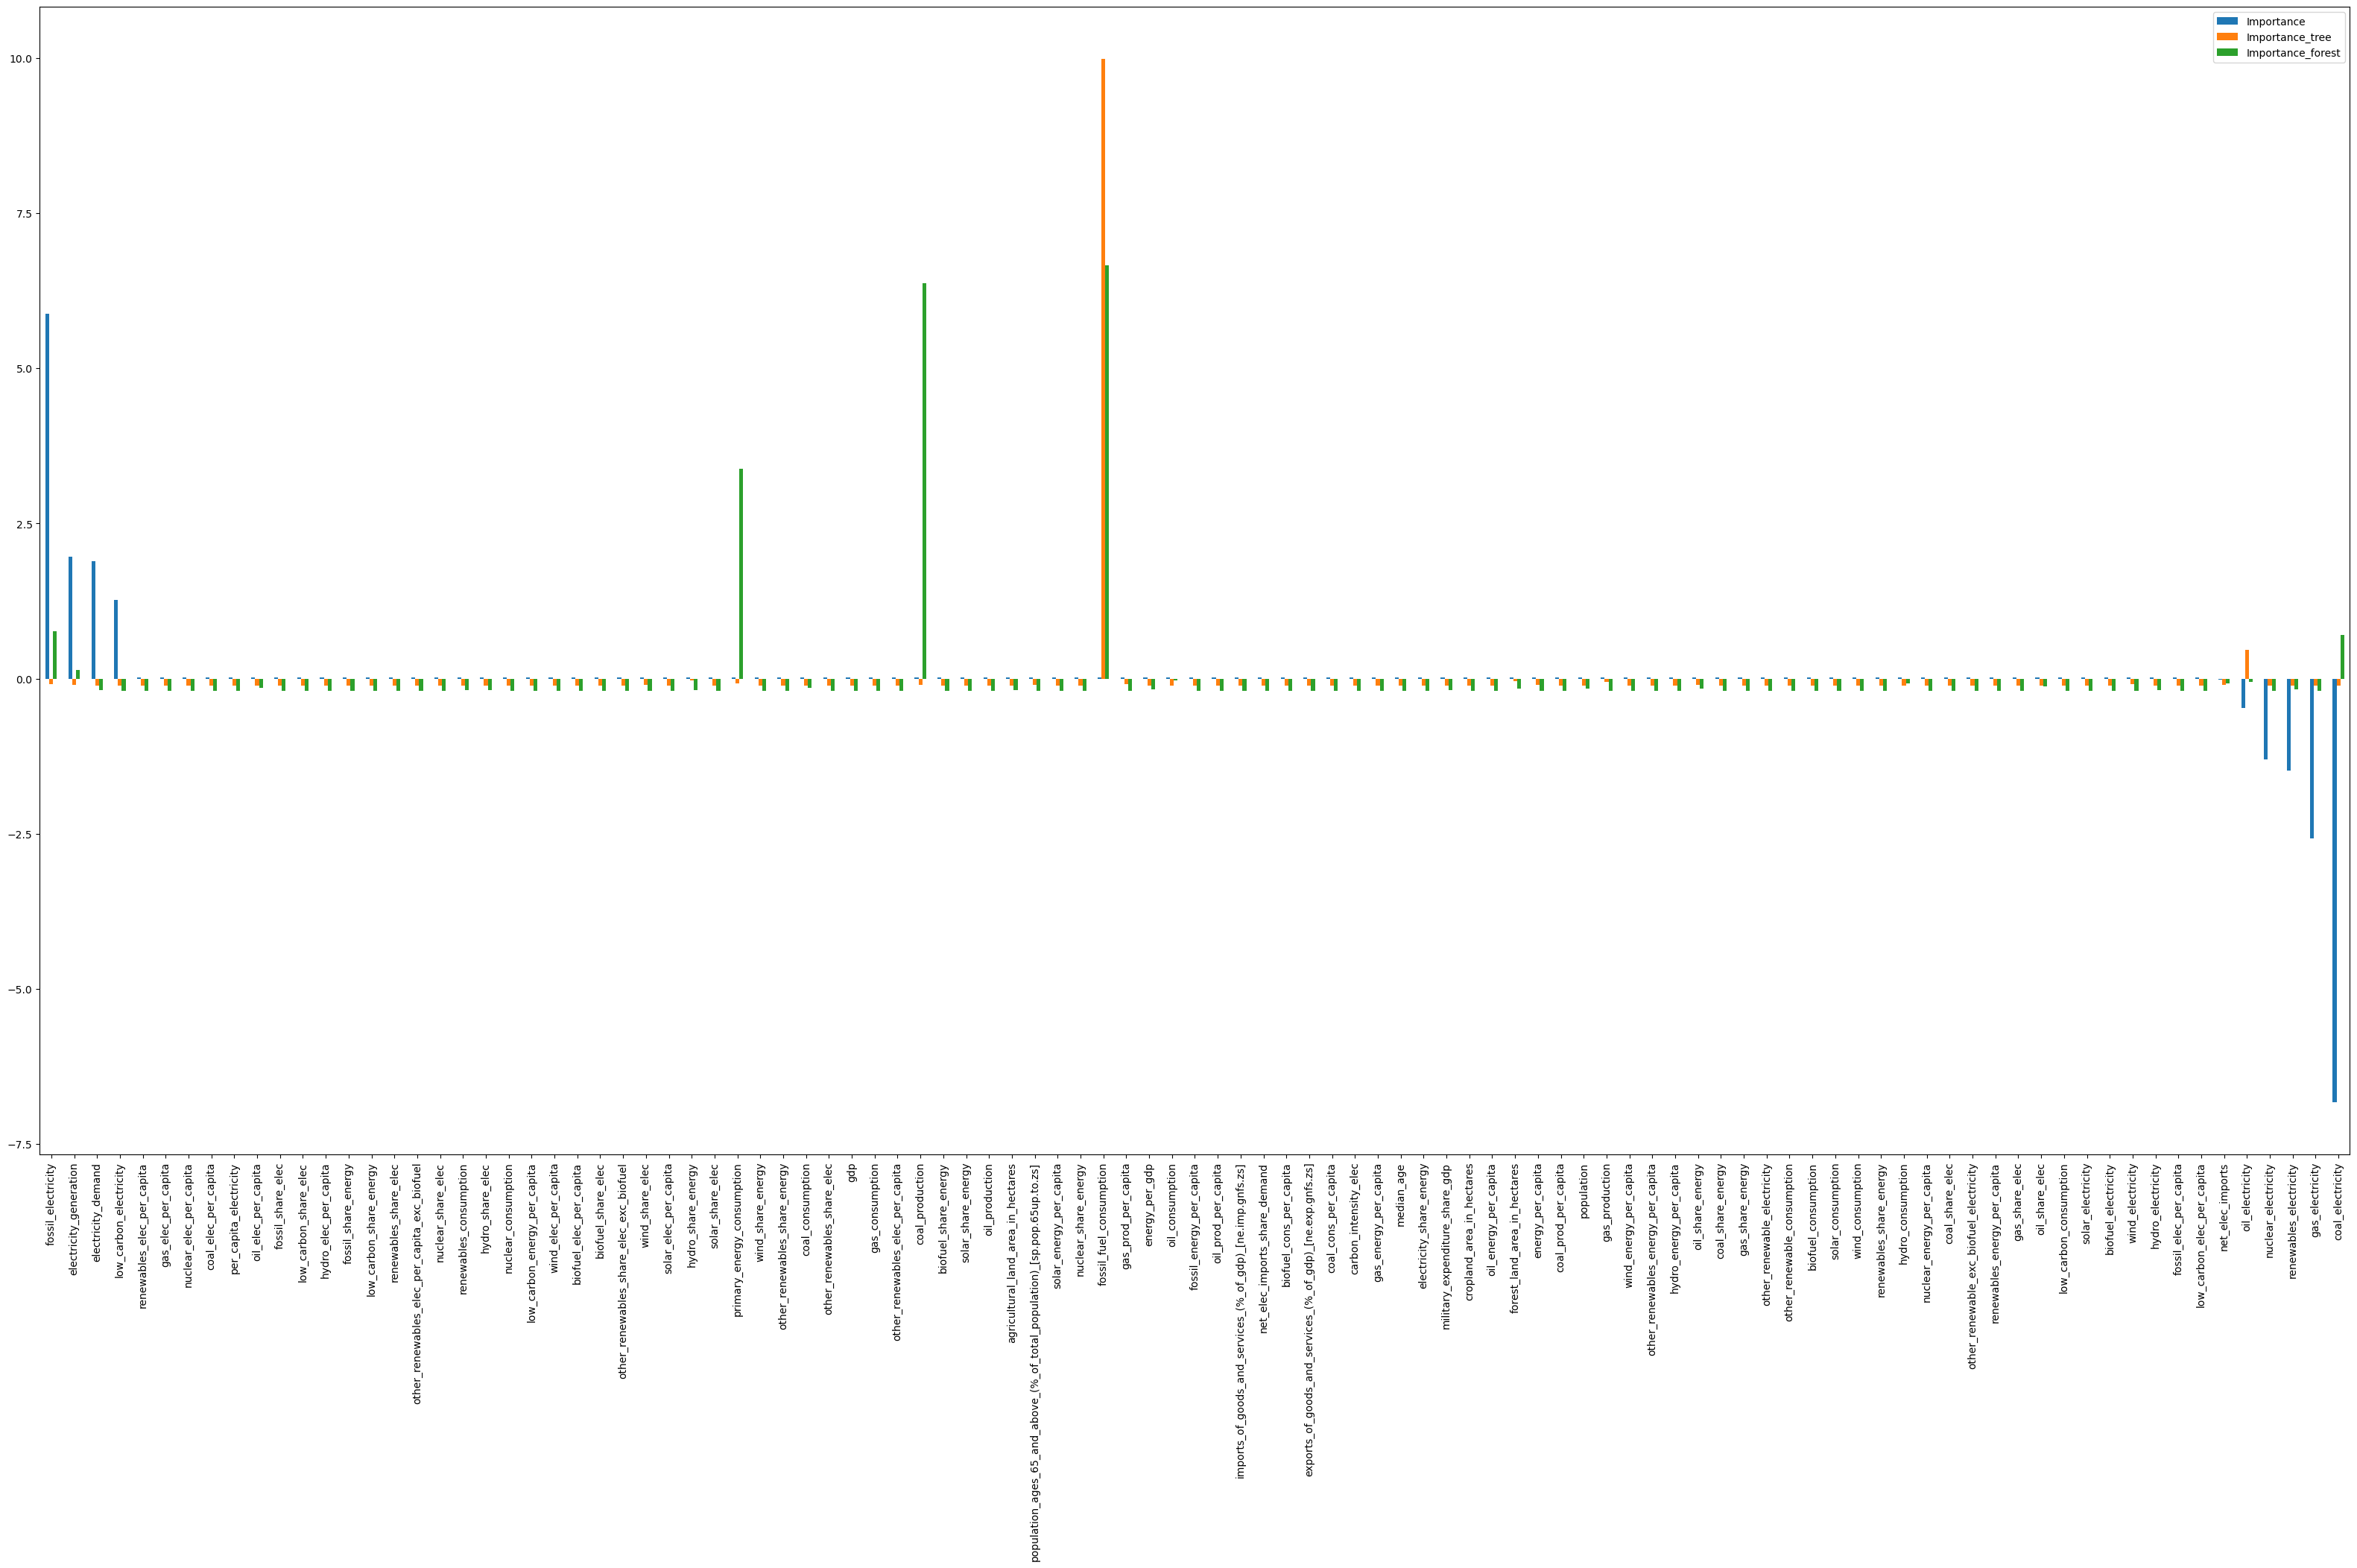

In [50]:

feature_importance.plot(kind='bar', figsize=(40,20))

In [80]:
feature_importance_ranked = feature_importance.rank()

In [94]:
linear_top_bottom_5 = feature_importance_ranked.Importance[(feature_importance_ranked.Importance<=4.0) | (feature_importance_ranked.Importance>=97.0)].index.tolist()
tree_top_bottom_5 = feature_importance_ranked.Importance_tree[feature_importance_ranked.Importance>=96.0].index.tolist()
forest_top_bottom_5 = feature_importance_ranked.Importance[feature_importance_ranked.Importance_forest>=96.0].index.tolist()

In [95]:
features = set()
features.update(linear_top_bottom_5)
features.update(tree_top_bottom_5)
features.update(forest_top_bottom_5)
len(features)

13

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X = dataframe[features]
y = dataframe['co2']

pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ('std_scalar', StandardScaler())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() #not doing any hyperparameter tuning right now.
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from src.models.predict_model import adjusted_r2
predictions = model.predict(X_train)
m_squared_error = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train, predictions)
a_r2_score = adjusted_r2(r2, len(y_train), len(features))
mean_abs_err = mean_absolute_error(y_train, predictions)
print(f"Mean Squared Error: {m_squared_error}, R2 Score: {r2}, Adjusted R2 score: {a_r2_score}, Mean Absolute Error {mean_abs_err}")

In [ ]:
test_predictions = model.predict(X_test)
m_squared_error = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)
a_r2_score = adjusted_r2(r2, len(y_test), len(features))
mean_abs_err = mean_absolute_error(y_test, test_predictions)
print(f"Mean Squared Error: {m_squared_error}, R2 Score: {r2}, Adjusted R2 score: {a_r2_score}, Mean Absolute Error {mean_abs_err}")

In [ ]:
from sklearn.linear_model import LinearRegression
dummy_model = LinearRegression() #fitting a simpler regressor to find a baseline.
dummy_model.fit(X_train, y_train)

In [ ]:
dummy_predictions = dummy_model.predict(X_train)
m_squared_error = mean_squared_error(y_train, dummy_predictions)
r2 = r2_score(y_train, dummy_predictions)
a_r2_score = adjusted_r2(r2, len(y_train), len(features))
mean_abs_err = mean_absolute_error(y_train, dummy_predictions)
print("Baseline using Linear Regression Strategy")
print(f"Mean Squared Error: {m_squared_error}, R2 Score: {r2}, Adjusted R2 score: {a_r2_score}, Mean Absolute Error {mean_abs_err}")

In [ ]:
dummy_test_predictions = dummy_model.predict(X_test)
m_squared_error = mean_squared_error(y_test, dummy_test_predictions)
r2 = r2_score(y_test, dummy_test_predictions)
a_r2_score = adjusted_r2(r2, len(y_test), len(features))
mean_abs_err = mean_absolute_error(y_test, dummy_test_predictions)
print("Baseline using Linear Regression Strategy")
print(f"Mean Squared Error: {m_squared_error}, R2 Score: {r2}, Adjusted R2 score: {a_r2_score}, Mean Absolute Error {mean_abs_err}")

R2 Score is higher for linear, but it has lower mean absolute error. Not sure which stat to go with here.